In [103]:
import pandas as pd 
import numpy as np 
from cmath import inf
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
grad = pd.read_csv("bases/base_metodo_gradiente_t=0.1_lote=1.csv")
estoc = pd.read_csv("bases/base_metodo_gradiente_mini_lote_t=1_lote=1.csv")
lote = pd.read_csv("bases/base_metodo_gradiente_mini_lote_t=1_lote=metade.csv")

In [72]:
prob_nao_resolv = grad[~grad.problema.isin(estoc.problema)].copy()

In [73]:
prob_nao_resolv

,problema,x_inicial,status,x_final,iter,objetivo,gradiente,norma,tempo
36,McKinnon,[0. 0.],sucesso,[ 0. -0.49950482],31,-0.24999975480071346,[0. 0.00099035],0.000990,0.000000
37,GaoHanAlmostQuadratic,[1. 1.],sucesso,[0.00033019 0.00020935],34,[[1.62793777e-07]],[0.00069339 0.00046162],0.000833,0.001995


In [74]:
prob_nao_resolv["x_inicial"] = np.NaN
prob_nao_resolv["status"] = np.NaN
prob_nao_resolv["x_final"] = np.NaN
prob_nao_resolv["iter"] = np.NaN
prob_nao_resolv["objetivo"] = np.NaN 
prob_nao_resolv["gradiente"] = np.NaN
prob_nao_resolv["norma"] = np.NaN
prob_nao_resolv["tempo"] = inf

In [75]:
lote_c = pd.concat([lote, prob_nao_resolv], axis = 0)
estoc_c = pd.concat([estoc, prob_nao_resolv], axis = 0)

In [76]:
grad["metodo"] = "gradiente"
estoc_c["metodo"] = "estoc"
lote_c["metodo"] = "lote"

df = pd.concat([grad, estoc_c, lote_c], axis = 0)

In [77]:
df.query("status == 'sucesso'").groupby("metodo", as_index = False)["tempo"].min()

,metodo,tempo
0,estoc,0.000000
1,gradiente,0.000000
2,lote,0.000993


In [78]:
df["tempo_teo"] = df["tempo"].apply(lambda x: 1e-8 if x == 0.000000 else x)

In [79]:
df.loc[(df.status != 'sucesso'), "tempo_teo"] = inf

In [80]:
minimos = df.query("status == 'sucesso'").groupby("metodo", as_index = False)["tempo_teo"].min()
minimos

,metodo,tempo_teo
0,estoc,1.000000e-08
1,gradiente,1.000000e-08
2,lote,9.927750e-04


In [81]:
df.loc[(df.metodo == 'estoc'), "tempo_teo_min"] = minimos.query("metodo == 'estoc'").tempo_teo.values[0]
df.loc[(df.metodo == 'gradiente'), "tempo_teo_min"] = minimos.query("metodo == 'gradiente'").tempo_teo.values[0]
df.loc[(df.metodo == 'lote'), "tempo_teo_min"] = minimos.query("metodo == 'lote'").tempo_teo.values[0]

In [82]:
df["rps"] = df["tempo_teo"] / df["tempo_teo_min"]

In [83]:
df["resolvido"] = df["status"].map(lambda x: 1 if x == 'sucesso' else 0)

In [84]:
df = df.sort_values(["metodo", "tempo_teo"])

In [92]:
df["card_resolvidos"] = df.groupby(["metodo"], as_index = False)["resolvido"].cumsum()

In [94]:
df["rho"] = df["card_resolvidos"] / len(df.problema.unique())

In [106]:
df.reset_index(drop = True, inplace= True)

Text(0.5, 1.0, 'Método lote')

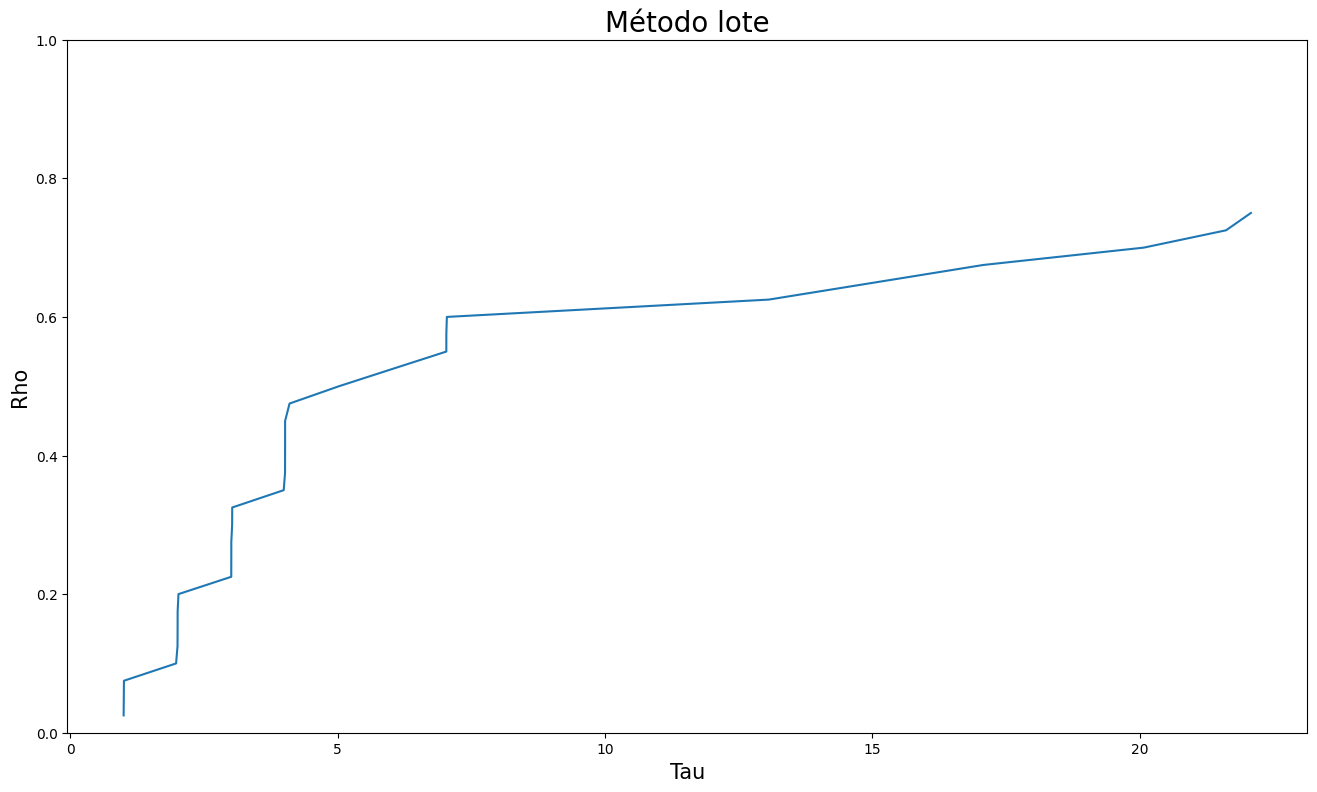

In [136]:
plt.figure(figsize = (16,9))
ax = sns.lineplot(x = "rps", y = "rho", data = df.query("rps < 50 and metodo == 'lote'"))
ax.set_ylim(0,1)
ax.set_xlabel("Tau", fontsize = 15)
ax.set_ylabel("Rho", fontsize = 15)
ax.set_title("Método lote", fontsize = 20)

Text(0.5, 1.0, 'Método Gradiente Descendente e Estocástico')

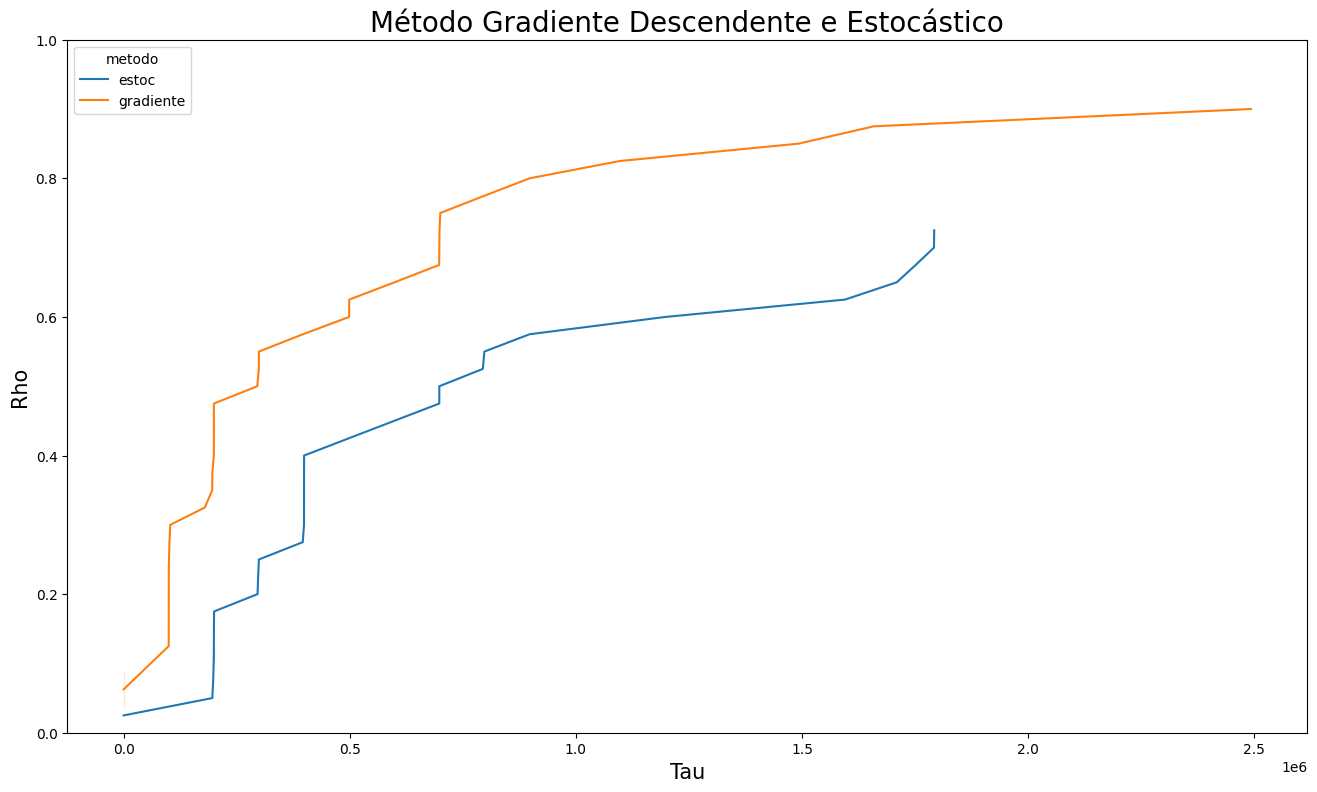

In [141]:
plt.figure(figsize = (16,9))
ax = sns.lineplot(x = "rps", y = "rho", data = df.query("rps < 5e6 and metodo != 'lote'"), hue = "metodo")
ax.set_ylim(0,1)
ax.set_xlabel("Tau", fontsize = 15)
ax.set_ylabel("Rho", fontsize = 15)
ax.set_title("Método Gradiente Descendente e Estocástico", fontsize = 20)

In [131]:
df.query("metodo == 'lote'").rps.describe()

count    40.000000
mean           inf
std            NaN
min       1.000000
25%       3.012908
50%       5.526777
75%            inf
max            inf
Name: rps, dtype: float64

In [132]:
df.query("metodo == 'estoc'").rps.describe()

count    4.000000e+01
mean              inf
std               NaN
min      1.000000e+00
25%      3.718019e+05
50%      7.461667e+05
75%      8.715975e+07
max               inf
Name: rps, dtype: float64

In [133]:
df.query("metodo == 'gradiente'").rps.describe()

count    4.000000e+01
mean              inf
std               NaN
min      1.000000e+00
25%      1.009047e+05
50%      2.971768e+05
75%      7.247746e+05
max               inf
Name: rps, dtype: float64